# Imbalanced data and ROC Curves

#### Alexei Stepanenko

Consider a binary classifer given by 
$$F(x) =  \begin{cases}
1 & \text{if } f(x) \geq 0 \\
0 & \text{if }f(x) < 0
\end{cases},$$ 
for some function $f: X \to \mathbb{R}$ (here, $X$ is the input space).

ROC curves are a method to evaluate the quality of the binary classifier. An advantage of this method is that is robust to imbalances in the dataset. 

**Aim:** We consider a simulated dataset  (refer to my previous notebook `PolClas`) in PyTorch.
1. Plot ROC curve for before and after training for a logistic regression model with polynomial features.
2. Do the same thing with an imbalanced dataset. 

We shall demonstrate that the AUC value behaves very differently to misclassification error for imbalanced datasets.

**References:** 
1. Cynthia Rudin's ML notes: https://users.cs.duke.edu/~cynthia/teaching.html
2. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math
import pandas as pd

## Dataset

The following code is from my previous notebook `PolClas` (with a few modifications) and contains the (random) data generation procedure, the model and some plotting methods. 

In [2]:
def give_arr_data(dataset_size, N , s , f):
    '''
    Gives array of predictor variables x_arr and array of target variables y_arr
    '''
    x_arr = np.random.uniform(low = -2, high = 2, size = (dataset_size,2)) # Predictor variables
    y_arr = []
    for x in x_arr:
        e = np.random.normal(scale = s, size = (2,))
        if f(x + e) >= 0: y_arr.append([1])
        else: y_arr.append([0])
    y_arr = np.array(y_arr) # Target variables
    return x_arr, y_arr

def x_to_xx(x_ts,M):
    '''
    Given torch tensor input in the form [x_0,x_1,x_2,...] where x_j is a (2,) tensor for each j, 
    returns [xx_0,xx_1,xx_2,...] where, for each j, xxj is a 1d tensor whose elements const of all non-constant monomials 
    of variables x_j[0] and x_j[1] with at most degree M (e.g.  for M = 2 elements are x_j[0], x_j[1], x_j[0]**2, x_j[1]**2, x_j[0]*x_j[1])
    '''
    xx_lst = []
    for n in range(len(x_ts)):
        xx = []
        x = x_ts[n]
        for i in range(M+1):
            for j in range(M+1):
                if i + j <= M and i + j > 0:
                    xx.append((x[0]**i)*(x[1]**j))
        xx_lst.append(xx)
    return torch.tensor(xx_lst)

def xx_to_z(xx_ts, mean, std):
    '''
    Rescales polynomial features xx_ts.
    mean and std should be computed as:
        mean = torch.mean(xx_train_ts, dim = 0)
        std = torch.std(xx_train_ts, dim = 0)
    '''
    
    std = torch.where(std != 0.0, std, torch.ones(std.shape)) # Avoid division by zero
    return (xx_ts - mean)/std 

def x_to_z(x_ts,M,mean,std): return xx_to_z(x_to_xx(x_ts,M),mean,std)

def give_error(dataset,model):
    '''
    Counting fraction of correct labels.
    '''
    (X, y) = dataset.tensors
    logit = model(X)
    y_pred = torch.where(logit >= 0, torch.ones_like(logit),torch.zeros_like(logit)) # Predictor for given x data
    pred_failures = torch.where(y_pred == y[:len(y_pred)],torch.zeros_like(logit),torch.ones_like(logit)) # Tensor of failures 1 or success 0 for each dataset 
    err = pred_failures.sum() # total number successes in batch
    return err/len(dataset)

class LinModel(nn.Module):
    def __init__(self,n):
        super(LinModel,self).__init__()
        self.lin = nn.Linear(n,1)
        #self.lin.weight = nn.Parameter(torch.zeros(n,1))def give_cost(data_loader, model, loss_fn):
        #self.lin.bias = nn.Parameter(torch.tensor([0.0]))
        
    def forward(self,x): 
        return self.lin(x)
    

class experiment:

    def __init__(self,N):
        self.N = N
        self.f_sd = 0.5 #  Standard deviation in coefficients of distribution
        self.f_coeff = np.random.normal(scale = 0.5, size= (N+1,N+1)) # Coefficients of distribution
    
    
    def f(self,x):
        N = self.N
        tmp = 0
        for i in range(self.N+1):
            for j in range(self.N+1):
                if i + j <= N: tmp += self.f_coeff[i,j]*(x[0]**i)*(x[1]**j)
        return tmp
    
    def plot_dist(self):
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                Z[i,j] = self.f([X0[i,j],X1[i,j]])
        plt.figure(figsize=(5, 5))
        plt.contour(X0,X1,Z, levels =[0], linestyles = '--')
        plt.xlim((-2,2))
        plt.ylim((-2,2))
        plt.title('Zero level set of $f$')
        plt.show()
    
    # N = 6
    s = 0.2 # Dataset noise (in target variable)
    dataset_size = 100
    validset_size = 100

    # Learning parameters
    learning_rate = 0.1
    n_epochs = 10000
    batch_size = 20
    weight_decay = 0

    # Capacity of model (polynomial degree)
    M = 12

    # Rate of printing
    n_print = 500 # Print after every `n_print` epochs
    
    model = None
    # History lists (recording every epoch)
    Jtr_hist = None # Training cost history 
    Jtst_hist = None # Testing cost history 
    
    mean = None
    std = None
    
    data_created = False
    x_arr, y_arr,  = None, None
    x_tst_arr, y_tst_arr  = None, None
    
    def gen_data(self): 
        if self.data_created == False:
            self.x_arr, self.y_arr = give_arr_data(self.dataset_size, self.N , self.s , self.f)
            self.x_tst_arr, self.y_tst_arr = give_arr_data(self.validset_size, self.N , self.s , self.f)
            self.data_created = True

        
    def go(self):
        N = self.N
        f = self.f
        s = self.s
        dataset_size = self.dataset_size
        validset_size = self.validset_size
        learning_rate = self.learning_rate
        n_epochs = self.n_epochs
        batch_size = self.batch_size
        M = self.M
        n_print = self.n_print
        weight_decay = self.weight_decay
        data_created = self.data_created
        
        if data_created == False:
            self.x_arr, self.y_arr = give_arr_data(dataset_size, N , s , f)
            self.x_tst_arr, self.y_tst_arr = give_arr_data(validset_size, N , s , f)
            x_arr, y_arr, x_tst_arr, y_tst_arr = self.x_arr, self.y_arr, self.x_tst_arr, self.y_tst_arr 
        else: 
            x_arr, y_arr, x_tst_arr, y_tst_arr = self.x_arr, self.y_arr, self.x_tst_arr, self.y_tst_arr 

            
        # Transforming training dataset
        x_ts = torch.from_numpy(x_arr); y_ts = torch.from_numpy(y_arr)
        xx_ts = x_to_xx(x_ts,M); 

        mean = torch.mean(xx_ts, dim = 0) # For rescaling
        std = torch.std(xx_ts, dim = 0)
        z_ts = xx_to_z(xx_ts, mean,std)

        z_ts = z_ts.type(torch.float32); y_ts = y_ts.type(torch.float32); # converting to single precision float
        dataset = TensorDataset(z_ts,y_ts)


        # Transforming testing dataset
        x_tst_ts = torch.from_numpy(x_tst_arr); y_tst_ts = torch.from_numpy(y_tst_arr)
        xx_tst_ts = x_to_xx(x_tst_ts,M)
        z_tst_ts = xx_to_z(xx_tst_ts, mean,std)

        z_tst_ts = z_tst_ts.type(torch.float32); y_tst_ts = y_tst_ts.type(torch.float32); # converting to single precision float
        dataset_tst = TensorDataset(z_tst_ts,y_tst_ts)

        Jtr_hist = []
        Jtst_hist = []
        
        # Specify traing and testing dataloaders. (By convention testing data has batch size = 1).
        data_train = DataLoader(dataset, batch_size = batch_size)
        data_tst = DataLoader(dataset_tst)

        # Initiating model
        model = LinModel(z_ts.shape[1])
        loss_fn = nn.BCEWithLogitsLoss() # https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
        
        tr_err = None
        tst_err = None
        

        for t in range(n_epochs):
            Jtr_epoch = 0.0 # Training cost for epoch
            for batch, (X,y) in enumerate(data_train):
                # Compute prediction and loss
                pred = model(X)
                loss = loss_fn(pred, y)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Recording loss
                Jtr_epoch += loss.item()

            Jtr_epoch = Jtr_epoch/len(data_train)
            Jtr_hist.append(Jtr_epoch)
            Jtst_epoch = give_error(dataset_tst, model)
            Jtst_hist.append(Jtst_epoch)

            # Printing every `n_print` epochs
            if t % n_print == 0:
                print(f"Epoch {t}. Training cost: {Jtr_epoch:>6f}. Testing error: {Jtst_epoch:>6f}")

        tr_err = give_error(dataset, model); tst_err = give_error(dataset_tst, model)
        print(f"End. Training error: {tr_err:>6f}. Testing error: {tst_err:>6f}")
        
        self.x_arr = x_arr; self.y_arr = y_arr; self.x_tst_arr = x_tst_arr; self.y_tst_arr = y_tst_arr;
        self.dataset = dataset; self.dataset_tst = dataset_tst;
        self.model = model
        self.Jtst_hist = Jtst_hist; self.Jtr_hist = Jtr_hist 
        self.mean = mean; self.std = std;
        self.tr_err = tr_err; self.tst_err = tst_err
        
        
    
    ps = 60 # Size of points in plot (def. 30)
    alpha = 0.5
    loc = 2
    
    def plot_model(self):
        x_arr = self.x_arr; y_arr = self.y_arr; x_tst_arr = self.x_tst_arr; y_tst_arr = self.y_tst_arr;
        dataset = self.dataset; dataset_tst = self.dataset_tst;
        model = self.model; f = self.f
        s = self.s; N = self.N; M = self.M; mean = self.mean; std = self.std
        
        ps = self.ps
        alpha = self.alpha

        fig, ax = plt.subplots(1,2, figsize = (21,10))

        ## Training data
        # Giving array of failures 
        (X, y) = dataset.tensors
        logit = model(X)
        y_pred = torch.where(logit >= 0, torch.ones_like(logit),torch.zeros_like(logit)) # Predictor for given x data
        pred_fail = torch.where(y_pred == y[:len(y_pred)],torch.zeros_like(logit),torch.ones_like(logit)) # Tensor of failures 1 or success 0 for each dataset 
        # Separating successfully and unsuccessfully predicted 0 and 1s
        x_0_succ = []
        x_0_fail = [] 
        x_1_succ = [] 
        x_1_fail = [] 
        for i in range(len(x_arr)):
            if y_arr[i][0] == 0:
                if pred_fail[i,0] == 1: x_0_fail.append(x_arr[i])
                else: x_0_succ.append(x_arr[i])
            else: 
                if pred_fail[i,0] == 1: x_1_fail.append(x_arr[i])
                else: x_1_succ.append(x_arr[i])
        x_0_succ = np.array(x_0_succ); x_0_fail = np.array(x_0_fail); x_1_succ = np.array(x_1_succ); x_1_fail = np.array(x_1_fail); 
        # Plotting
        if len(x_0_fail) > 0:  ax[0].scatter(x_0_fail.transpose()[0],x_0_fail.transpose()[1], color = 'red', marker = 'x', s = ps+10)
        if len(x_1_fail) > 0:  ax[0].scatter(x_1_fail.transpose()[0],x_1_fail.transpose()[1], color = 'red', marker = 'x', s = ps+10)
        if len(x_0_succ) > 0:  ax[0].scatter(x_0_succ.transpose()[0],x_0_succ.transpose()[1], color = 'orange', s = ps, alpha = alpha)
        if len(x_1_succ) > 0: ax[0].scatter(x_1_succ.transpose()[0],x_1_succ.transpose()[1], color = 'blue', s = ps, alpha = alpha)
        if len(x_0_fail) > 0:  ax[0].scatter(x_0_fail.transpose()[0],x_0_fail.transpose()[1], color = 'orange', s = ps, alpha = alpha)
        if len(x_1_fail) > 0: ax[0].scatter(x_1_fail.transpose()[0],x_1_fail.transpose()[1], color = 'blue', s = ps, alpha = alpha)
        ax[0].scatter([],[],color = 'orange', label = 'y = 0')
        ax[0].scatter([],[],color = 'blue', label = 'y = 1')
        ax[0].scatter([],[], color = 'red', marker = 'x', label = 'Failure')
        ax[0].set_xlim((-2,2))
        ax[0].set_ylim((-2,2))
        # Zero level set for prob-dist function f
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                Z[i,j] = f([X0[i,j],X1[i,j]])
        ax[0].contour(X0,X1,Z, levels =[0], linestyles = '--',colors = 'black')
        ax[0].plot([],color = 'black',linestyle = '--',label = 'Distribution 0-level-set')
        ax[0].plot([])
        # Zero level set for model
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                x = torch.tensor([[X0[i,j],X1[i,j]]])
                z = x_to_z(x,M,mean,std).to(torch.float32)
                Z[i,j] = model(z).item()
        ax[0].contour(X0,X1,Z, levels =[0], colors = 'green')
        ax[0].plot([],color = 'green',label = 'Model decision boundary')
        ax[0].legend(loc = self.loc)
        ax[0].title.set_text('Training data')
        ax[0].title.set_size(15)

        ## Validation data
        # Giving array of failures 
        (X, y) = dataset_tst.tensors
        logit = model(X)
        y_pred = torch.where(logit >= 0, torch.ones_like(logit),torch.zeros_like(logit)) # Predictor for given x data
        pred_fail = torch.where(y_pred == y[:len(y_pred)],torch.zeros_like(logit),torch.ones_like(logit)) # Tensor of failures 1 or success 0 for each dataset 
        # Separating successfully and unsuccessfully predicted 0 and 1s
        x_0_succ = []
        x_0_fail = [] 
        x_1_succ = [] 
        x_1_fail = [] 
        for i in range(len(x_tst_arr)):
            if y_tst_arr[i][0] == 0:
                if pred_fail[i,0] == 1: x_0_fail.append(x_tst_arr[i])
                else: x_0_succ.append(x_tst_arr[i])
            else: 
                if pred_fail[i,0] == 1: x_1_fail.append(x_tst_arr[i])
                else: x_1_succ.append(x_tst_arr[i])
        x_0_succ = np.array(x_0_succ); x_0_fail = np.array(x_0_fail); x_1_succ = np.array(x_1_succ); x_1_fail = np.array(x_1_fail); 
        # Plotting
        if len(x_0_fail) > 0:  ax[1].scatter(x_0_fail.transpose()[0],x_0_fail.transpose()[1], color = 'red', marker = 'x', s = ps+10)
        if len(x_1_fail) > 0:  ax[1].scatter(x_1_fail.transpose()[0],x_1_fail.transpose()[1], color = 'red', marker = 'x', s = ps+10)
        if len(x_0_succ) > 0:  ax[1].scatter(x_0_succ.transpose()[0],x_0_succ.transpose()[1], color = 'orange', s = ps, alpha = alpha)
        if len(x_1_succ) > 0: ax[1].scatter(x_1_succ.transpose()[0],x_1_succ.transpose()[1], color = 'blue', s = ps, alpha = alpha)
        if len(x_0_fail) > 0:  ax[1].scatter(x_0_fail.transpose()[0],x_0_fail.transpose()[1], color = 'orange', s = ps, alpha = alpha)
        if len(x_1_fail) > 0: ax[1].scatter(x_1_fail.transpose()[0],x_1_fail.transpose()[1],color = 'blue', s = ps, alpha = alpha)
        ax[1].scatter([],[],color = 'orange', label = 'y = 0')
        ax[1].scatter([],[],color = 'blue', label = 'y = 1')
        ax[1].scatter([],[], color = 'red', marker = 'x', label = 'Failure')
        ax[1].set_xlim((-2,2))
        ax[1].set_ylim((-2,2))
        # Zero level set for prob-dist function f
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                Z[i,j] = f([X0[i,j],X1[i,j]])
        ax[1].contour(X0,X1,Z, levels =[0], linestyles = '--',colors = 'black')
        ax[1].plot([],color = 'black',linestyle = '--',label = 'Distribution 0-level-set')
        ax[1].plot([])
        # Zero level set for model
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                x = torch.tensor([[X0[i,j],X1[i,j]]])
                z = x_to_z(x,M,mean,std).to(torch.float32)
                Z[i,j] = model(z).item()
        ax[1].contour(X0,X1,Z, levels =[0], colors = 'green')
        ax[1].plot([],color = 'green',label = 'Model decision boundary')
        ax[1].legend(loc = self.loc)
        ax[1].title.set_text('Validation data')
        ax[1].title.set_size(15)

        fig.suptitle(f's = {s}, M = {M}, N = {N}', fontsize = 20)
        plt.show()
        

    def plot_data(self):
        x_arr = self.x_arr; y_arr = self.y_arr; x_tst_arr = self.x_tst_arr; y_tst_arr = self.y_tst_arr; f = self.f
        
        ps = self.ps; alpha = self.alpha; s = self.s; N = self.N; M = self.M;

        fig, ax = plt.subplots(1,2, figsize = (21,10))

        ## Training data
        # Separating postitive and negative datapoints
        x_0 = []
        x_1 = [] 
        for i in range(len(x_arr)):
            if y_arr[i][0] == 0:
                x_0.append(x_arr[i])
            else: 
                x_1.append(x_arr[i])
        x_0 = np.array(x_0); x_1 = np.array(x_1)
        # Plotting
        if len(x_0) > 0:  ax[0].scatter(x_0.transpose()[0],x_0.transpose()[1], color = 'orange', s = ps, alpha = alpha)
        if len(x_1) > 0: ax[0].scatter(x_1.transpose()[0],x_1.transpose()[1], color = 'blue', s = ps, alpha = alpha)
        ax[0].scatter([],[],color = 'orange', label = 'y = 0')
        ax[0].scatter([],[],color = 'blue', label = 'y = 1')
        ax[0].legend()
        ax[0].set_xlim((-2,2))
        ax[0].set_ylim((-2,2))
        # Zero level set for prob-dist function f
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                Z[i,j] = f([X0[i,j],X1[i,j]])
        ax[0].contour(X0,X1,Z, levels =[0], linestyles = '--',colors = 'black')
        ax[0].plot([])
        ax[0].set_title('Training data')

        ## Validation data
        # Separating postitive and negative datapoints
        x_0 = []
        x_1 = [] 
        for i in range(len(x_tst_arr)):
            if y_tst_arr[i][0] == 0:
                x_0.append(x_tst_arr[i])
            else: 
                x_1.append(x_tst_arr[i])
        x_0 = np.array(x_0); x_1 = np.array(x_1)
        # Plotting
        if len(x_0) > 0:  ax[1].scatter(x_0.transpose()[0],x_0.transpose()[1], color = 'orange', s = ps, alpha = alpha)
        if len(x_1) > 0: ax[1].scatter(x_1.transpose()[0],x_1.transpose()[1], color = 'blue', s = ps, alpha = alpha)
        ax[1].scatter([],[],color = 'orange', label = 'y = 0')
        ax[1].scatter([],[],color = 'blue', label = 'y = 1')
        ax[1].legend()
        ax[1].set_xlim((-2,2))
        ax[1].set_ylim((-2,2))
        # Zero level set for prob-dist function f
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                Z[i,j] = f([X0[i,j],X1[i,j]])
        ax[1].contour(X0,X1,Z, levels =[0], linestyles = '--',colors = 'black')
        ax[1].plot([])
        ax[1].set_title('Validation data')

        fig.suptitle(f's = {s}, M = {M}, N = {N}', fontsize = 20)
        plt.show()
        

The dataset looks like this. 

In [3]:
exp = experiment(N = 3) # N is a parameter for the data generation 

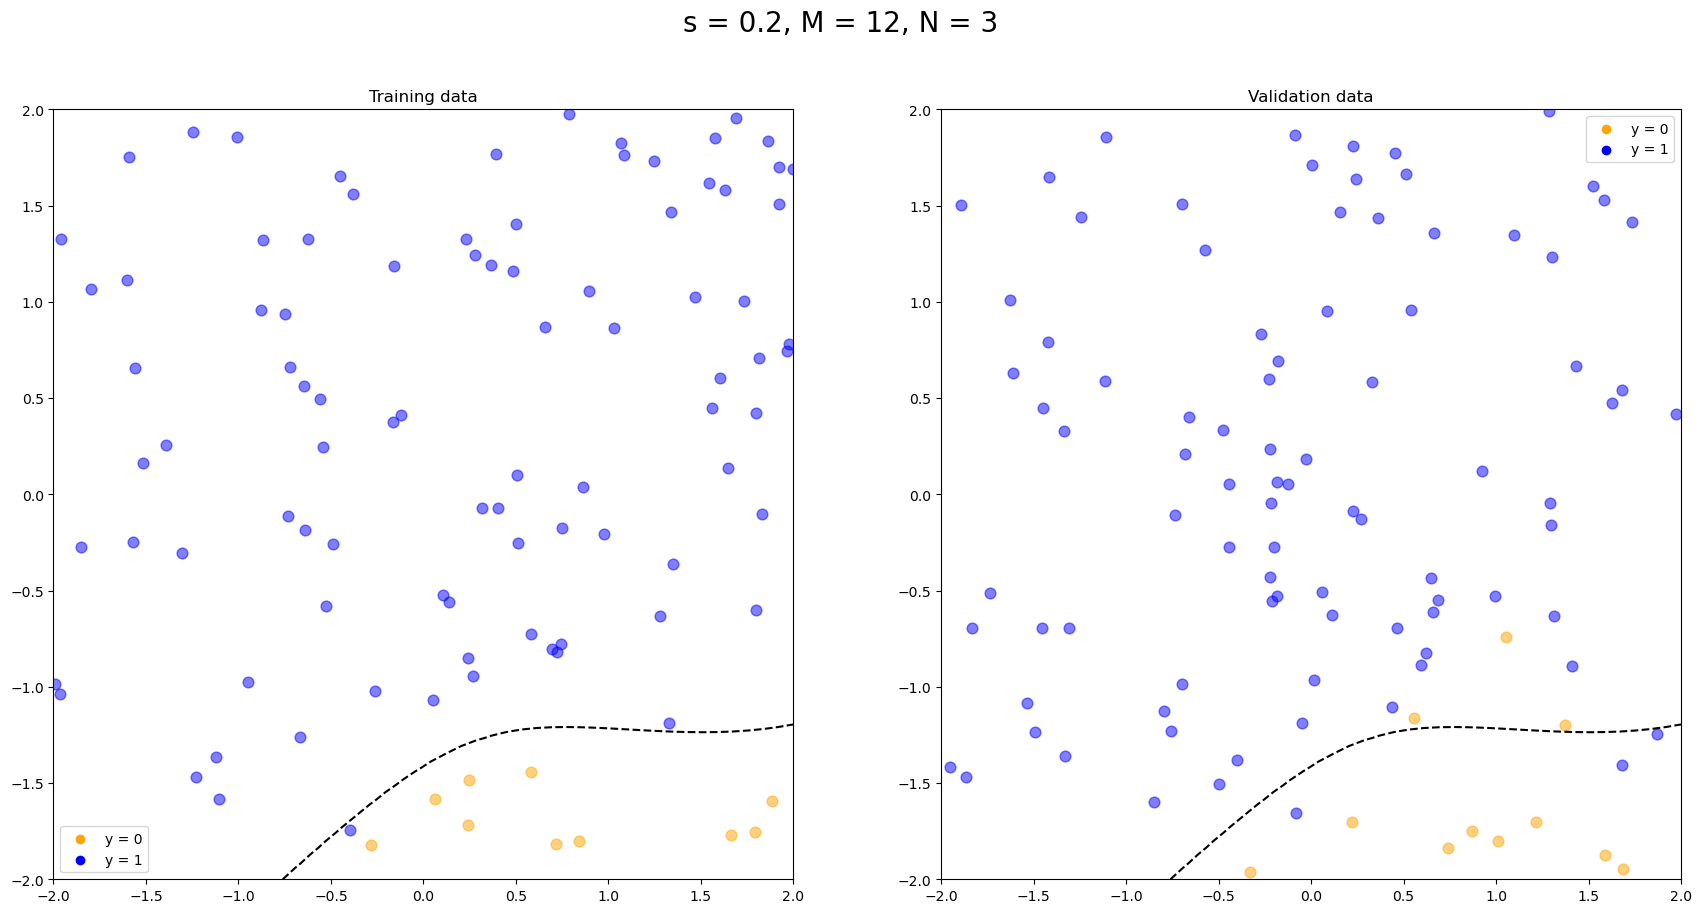

In [4]:
exp.s = 0.2 # Dataset noise (in target variable)
exp.dataset_size = 100
exp.validset_size = 100

exp.gen_data()
exp.plot_data()

We define a logistic regression model with polynomial features and plot decision boundary for the untrained model.

In [5]:
exp.M = 3 # Capacity of model (polynomial degree)
exp.n_epochs = 0 # No training

End. Training error: 0.640000. Testing error: 0.670000


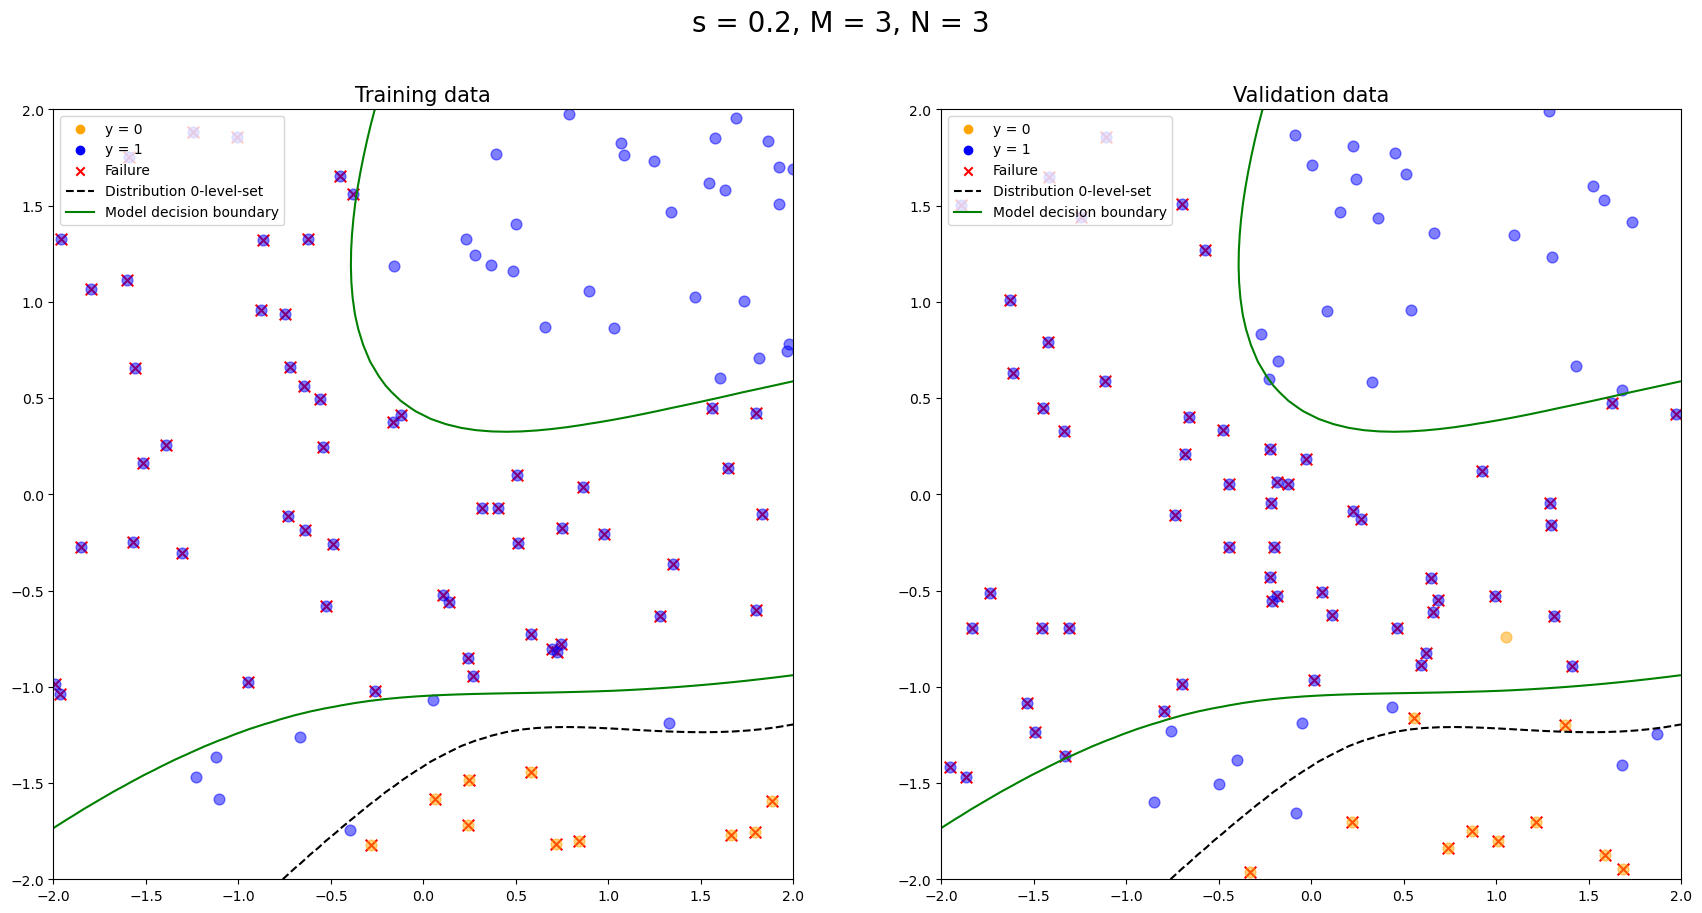

In [6]:
exp.go()
exp.plot_model()

Saving the untrained model for later.

In [7]:
untrained_model = exp.model

Next we train the model with gradient descent.

In [8]:
# Learning parameters
exp.learning_rate = 0.1
exp.n_epochs = 4000
exp.batch_size = 20
exp.n_print = 2000 # Print after every `n_print` epochs
exp.go()

Epoch 0. Training cost: 0.549183. Testing error: 0.140000
Epoch 2000. Training cost: 0.016628. Testing error: 0.050000
End. Training error: 0.000000. Testing error: 0.050000


Plotting the decision boundary for the trained model.

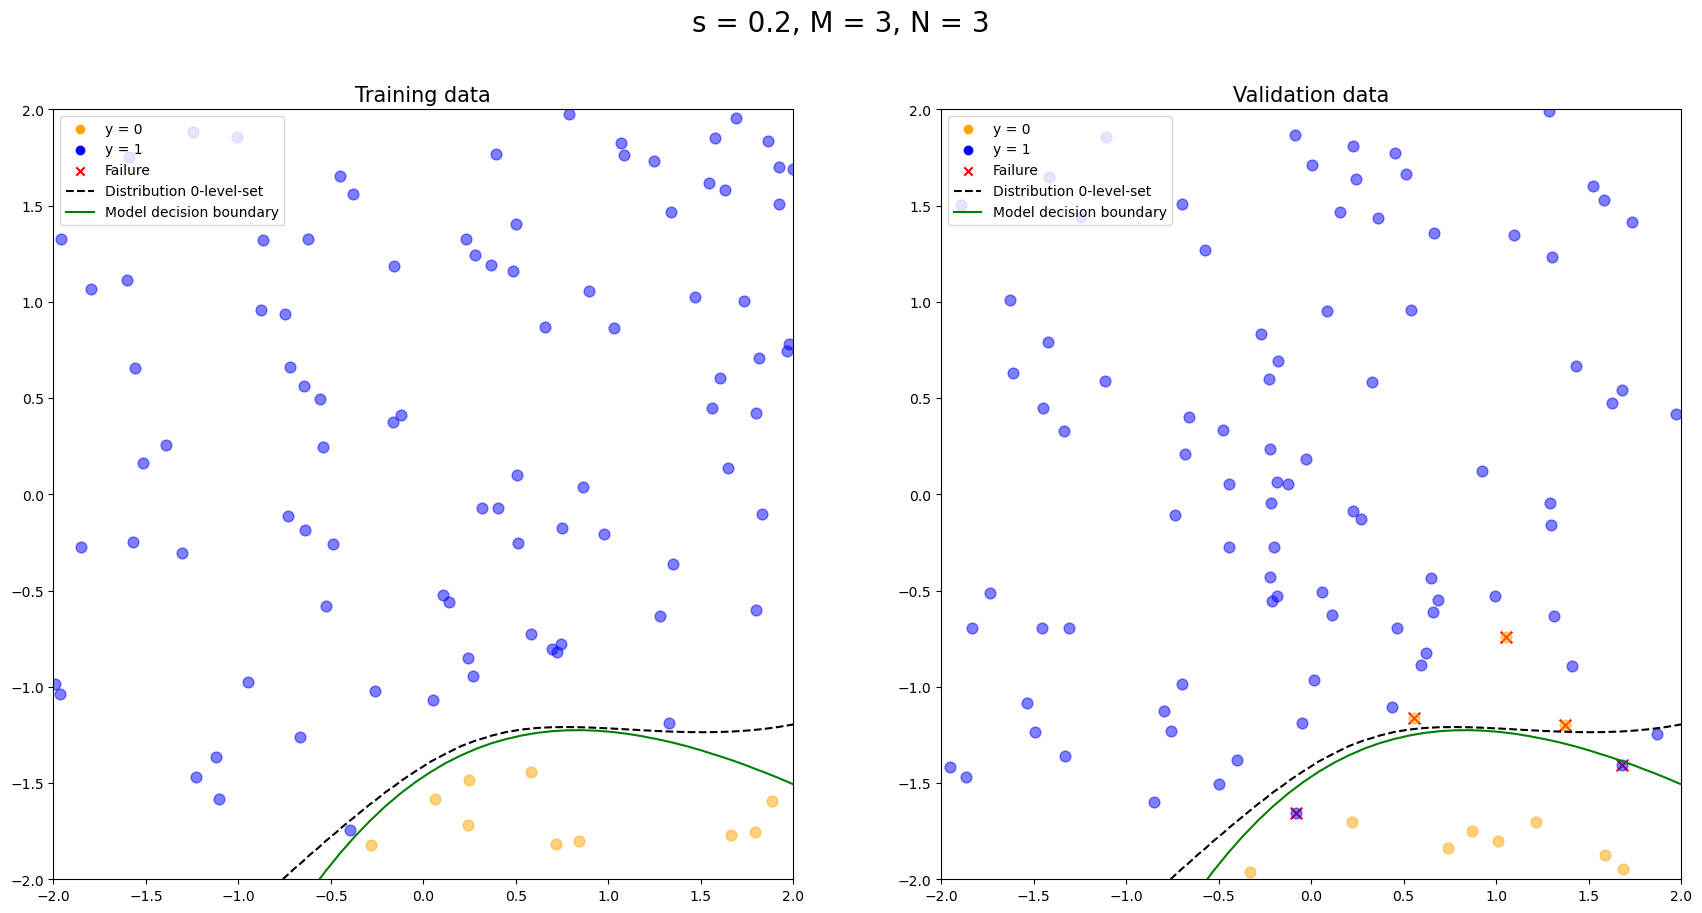

In [9]:
exp.plot_model()

Saving the trained model.

In [10]:
trained_model = exp.model

## ROC curves and AUC

Define a family of classifiers by 
$$F_\theta(x) = \begin{cases}1 & \text{if } f(x) \geq \theta \\
0 & \text{if }f(x) < \theta
\end{cases}, \qquad \theta \in \mathbb{R}. $$
The original classifier corresponds to $\theta = 0$ (i.e. $F(x) = F_0(x)$). 

Recall that the *true positive rate*  for a classifier is defined as
$$TPR = \frac{\#TP}{\# P}$$
where $\# P$ (positive) is the number of datapoints in the validation set with a positive label $y = 1$ and $\# TP$ (true positive) is the number of correctly classified datapoints with a positive label.  Recall that *false positive rate* is defined as 
$$FPR = \frac{\#FP}{\# N}$$
where $\# N$ (negative) is the number of datapoints with a negative label $y = 0$ and $\# FP$ (false positive) is the number of incorrectly classified datapoints with a positive label.

**Definition:**
The ROC curve is $(FPR(\theta),TPR(\theta))_{\theta \in \mathbb{R}}$, where $TPR(\theta)$ and $FPR(\theta)$ are the true/false positive rates for the classifer $F_\theta$. In other words, we plot $TPR(\theta) \in [0,1]$ against $FPR(\theta) \in [0,1]$. 

**Definition:**
The AUC is defined as the area under the ROC curve. 

The AUC always takes values between 0 and 1. 
- The closer the AUC is to 1, the better the classifer is.
- An AUC of $\tfrac{1}{2}$ corresponds to randomly guessing. 
- If the AUC is $< \tfrac{1}{2}$, then the classifier is so bad that we can obtain a better classifer by flipping all of the predictions.
    

#### Decision boundary of $F_\theta$

Let's first visualise the classifer $F_\theta$ by plotting it's decision boundary (i.e. the level sets $\{f(x) = \theta\}$) with different values of $\theta$, where $f$ is given by the trained model above. 

In [11]:
def split_x_set(x_arr,y_arr):
    '''
    Splits the input dataset x_arr according to whether y = 0 or 1
    '''
    I = range(len(x_arr))
    x0_lst = x_arr[[i for i in I if y_arr[i][0] == 0]]
    x1_lst = x_arr[[i for i in I if y_arr[i][0] == 1]], 
    return np.array(x0_lst), np.array(x1_lst)

In [12]:
theta_trained = 10 # positive and negative level set value for trained decision boundary
theta_untrained = 0.5 # positive and negative level set value for untrained decision boundary

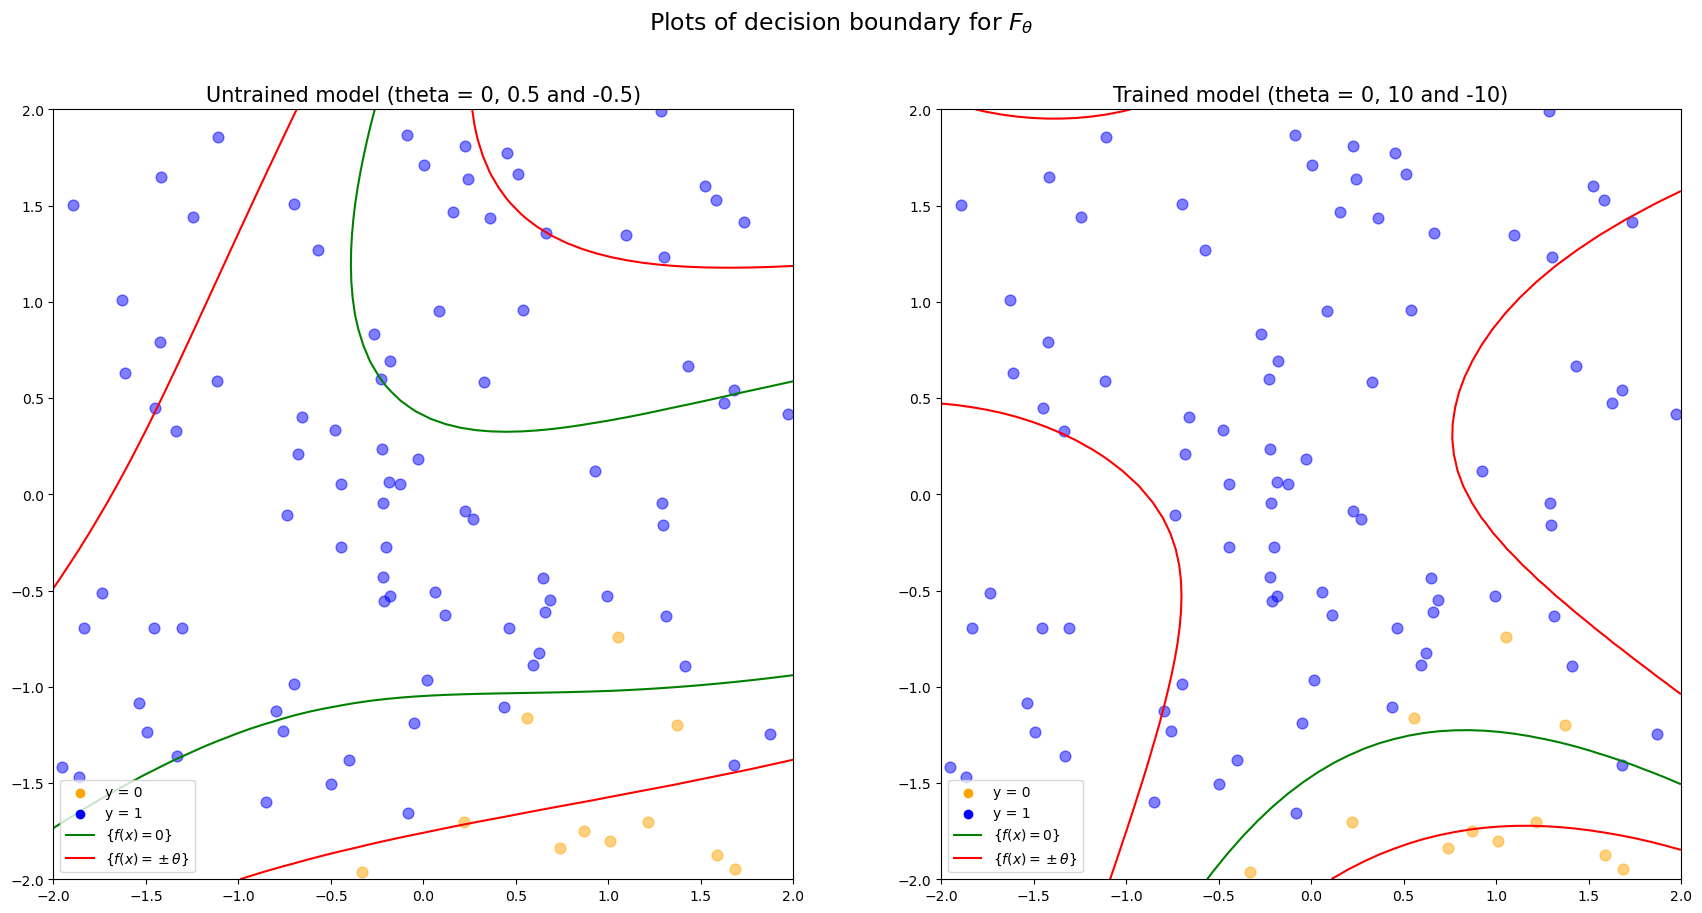

In [13]:
fig, ax = plt.subplots(1,2, figsize = (21,10))
## Training data
# Separating postitive and negative datapoints
x_arr = exp.x_tst_arr
y_arr = exp.y_tst_arr
x_0, x_1 = split_x_set(x_arr,y_arr)
# Plotting
if len(x_0) > 0:  ax[0].scatter(x_0.transpose()[0],x_0.transpose()[1], color = 'orange', s = exp.ps, alpha = exp.alpha)
if len(x_1) > 0: ax[0].scatter(x_1.transpose()[0],x_1.transpose()[1], color = 'blue', s = exp.ps, alpha = exp.alpha)
ax[0].scatter([],[],color = 'orange', label = 'y = 0')
ax[0].scatter([],[],color = 'blue', label = 'y = 1')
ax[0].set_xlim((-2,2))
ax[0].set_ylim((-2,2))
## Level sets for model separation function f
# trained model
X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
Z = np.zeros((len(X0),len(X1)))
for i in range(50):
    for j in range(50):
        x = torch.tensor([[X0[i,j],X1[i,j]]])
        z = x_to_z(x,exp.M,exp.mean,exp.std).to(torch.float32)
        Z[i,j] = untrained_model(z).item()
ax[0].contour(X0,X1,Z, levels =[0], colors = 'green')
ax[0].contour(X0,X1,Z, levels =[theta_untrained], colors = 'red')
ax[0].contour(X0,X1,Z, levels =[-theta_untrained], colors = 'red', linestyles = 'solid')
ax[0].plot([],color = 'green',label = r'$\{f(x) = 0\}$')
ax[0].plot([],color = 'red',label = r'$\{f(x) = \pm \theta\}$')
ax[0].set_title(f'Untrained model (theta = 0, {theta_untrained} and -{theta_untrained})',size = 15)
ax[0].legend()
# Plotting
if len(x_0) > 0:  ax[1].scatter(x_0.transpose()[0],x_0.transpose()[1], color = 'orange', s = exp.ps, alpha = exp.alpha)
if len(x_1) > 0: ax[1].scatter(x_1.transpose()[0],x_1.transpose()[1], color = 'blue', s = exp.ps, alpha = exp.alpha)
ax[1].scatter([],[],color = 'orange', label = 'y = 0')
ax[1].scatter([],[],color = 'blue', label = 'y = 1')
ax[1].set_xlim((-2,2))
ax[1].set_ylim((-2,2))
## Level sets for model separation function f
# trained model
X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
Z = np.zeros((len(X0),len(X1)))
for i in range(50):
    for j in range(50):
        x = torch.tensor([[X0[i,j],X1[i,j]]])
        z = x_to_z(x,exp.M,exp.mean,exp.std).to(torch.float32)
        Z[i,j] = trained_model(z).item()
ax[1].contour(X0,X1,Z, levels =[0], colors = 'green')
ax[1].contour(X0,X1,Z, levels =[theta_trained], colors = 'red')
ax[1].contour(X0,X1,Z, levels =[-theta_trained], colors = 'red', linestyles = 'solid')
ax[1].plot([],color = 'green',label = r'$\{f(x) = 0\}$')
ax[1].plot([],color = 'red',label = r'$\{f(x) = \pm \theta\}$')
ax[1].set_title(f'Trained model (theta = 0, {theta_trained} and -{theta_trained})',size = 15)
ax[1].legend()
fig.suptitle(r'Plots of decision boundary for $F_\theta$',size = 17)
plt.show()

#### Plot of ROC curve

Next, we compute the ROC curve and the AUC index for the trained and untrained models above. 

Note: This implementation is only intended for demonstrational purposes and is not optimised for large datasets since we use a raw python `for` loop. See `sklearn.metrics.roc_curve` for practical use. 

In [14]:
def transform(x_arr):
    x_ts = torch.tensor(x_arr)
    return x_to_z(x_ts,exp.M,exp.mean,exp.std).to(torch.float32)

In [15]:
def give_ROC_AUC(model,x_arr,y_arr,transform = transform):
    '''
    Given:
        - numpy array `x_arr` of input validation datapoints (mx2 array for validation set of size m)  
        - numpy array `y_arr` target validation datapoints (mx1 array)
        - PyTorch Model `model`
        - transform function `transform` so that model can operate on `transform(x_arr)`
    Returns:
        - ROC curve `ROC` (nested list, each element of ROC is of form [FPR,TPR])
        - AUC value (float)
    '''
    z_ts = transform(x_arr)
    f_X = model(z_ts).detach().numpy().T[0] # array [f(x_1),f(x_2),...] 
    sort_ind = np.flip(np.argsort(f_X)) # Indices for sorted (from negative to positive) version of [f(x_1),f(x_2),...] 
    y_lst = list(y_arr.transpose()[0])
    N = len([i for i in y_lst if i == 0]) # Number of negative examples in validation set
    P = len([i for i in y_lst if i == 1]) # Number of positive examples in validation set
    ## Main loop
    TP = 0 # True positive
    FP = 0 # False positive
    ROC = [[0,0]]
    AUC = 0
    for i in sort_ind:
        if y_lst[i] == 1: 
            TP += 1
            ROC.append([FP/N,TP/P])
        else: 
            FP += 1
            ROC.append([FP/N,TP/P])
            AUC += TP/(N*P)
    return ROC, AUC

In [16]:
x_arr = exp.x_tst_arr; y_arr = exp.y_tst_arr
ROC_trained, AUC_trained = give_ROC_AUC(trained_model,x_arr,y_arr)
ROC_untrained, AUC_untrained = give_ROC_AUC(untrained_model,x_arr,y_arr)

In [17]:
# Transforming for below plots
ROC_trained_t = np.array(ROC_trained).transpose(); ROC_untrained_t = np.array(ROC_untrained).transpose()

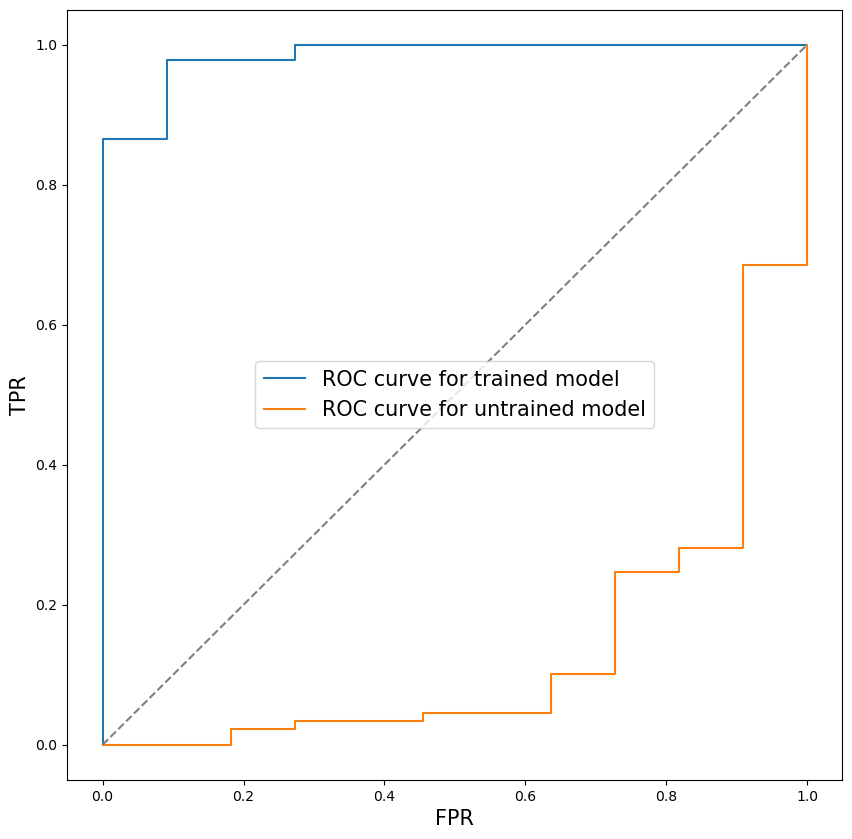

In [18]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
ax.plot(ROC_trained_t[0],ROC_trained_t[1], label = 'ROC curve for trained model')
ax.plot(ROC_untrained_t[0],ROC_untrained_t[1], label = 'ROC curve for untrained model')
ax.plot([0,1],[0,1], color = 'gray', linestyle = '--')
ax.legend(prop={'size': 15})
ax.set_xlabel('FPR', size = 15)
ax.set_ylabel('TPR', size = 15)
plt.show()

In [19]:
print('AUC value for trained model: ', AUC_trained)
print('AUC value for untrained model: ', AUC_untrained)


AUC value for trained model:  0.9836567926455569
AUC value for untrained model:  0.13585291113381


Repeating the experiment with a new random set of data, and a new randomly initialised untrained model, may yield a very different untrained AUC value, however, the trained AUC value is always high.  

Note that plotting FNR against TNR gives the same ROC curve.

## ROC and AUC for imbalanced data

In [20]:
exp = experiment(N = 3) # N is a parameter for the data generation 

#### Balanced data

In [21]:
# Generating "balanced" dataset first
exp.s = 0.4 # Dataset noise (in target variable)
exp.dataset_size = 400
exp.validset_size = 400
exp.data_created = False
exp.gen_data()

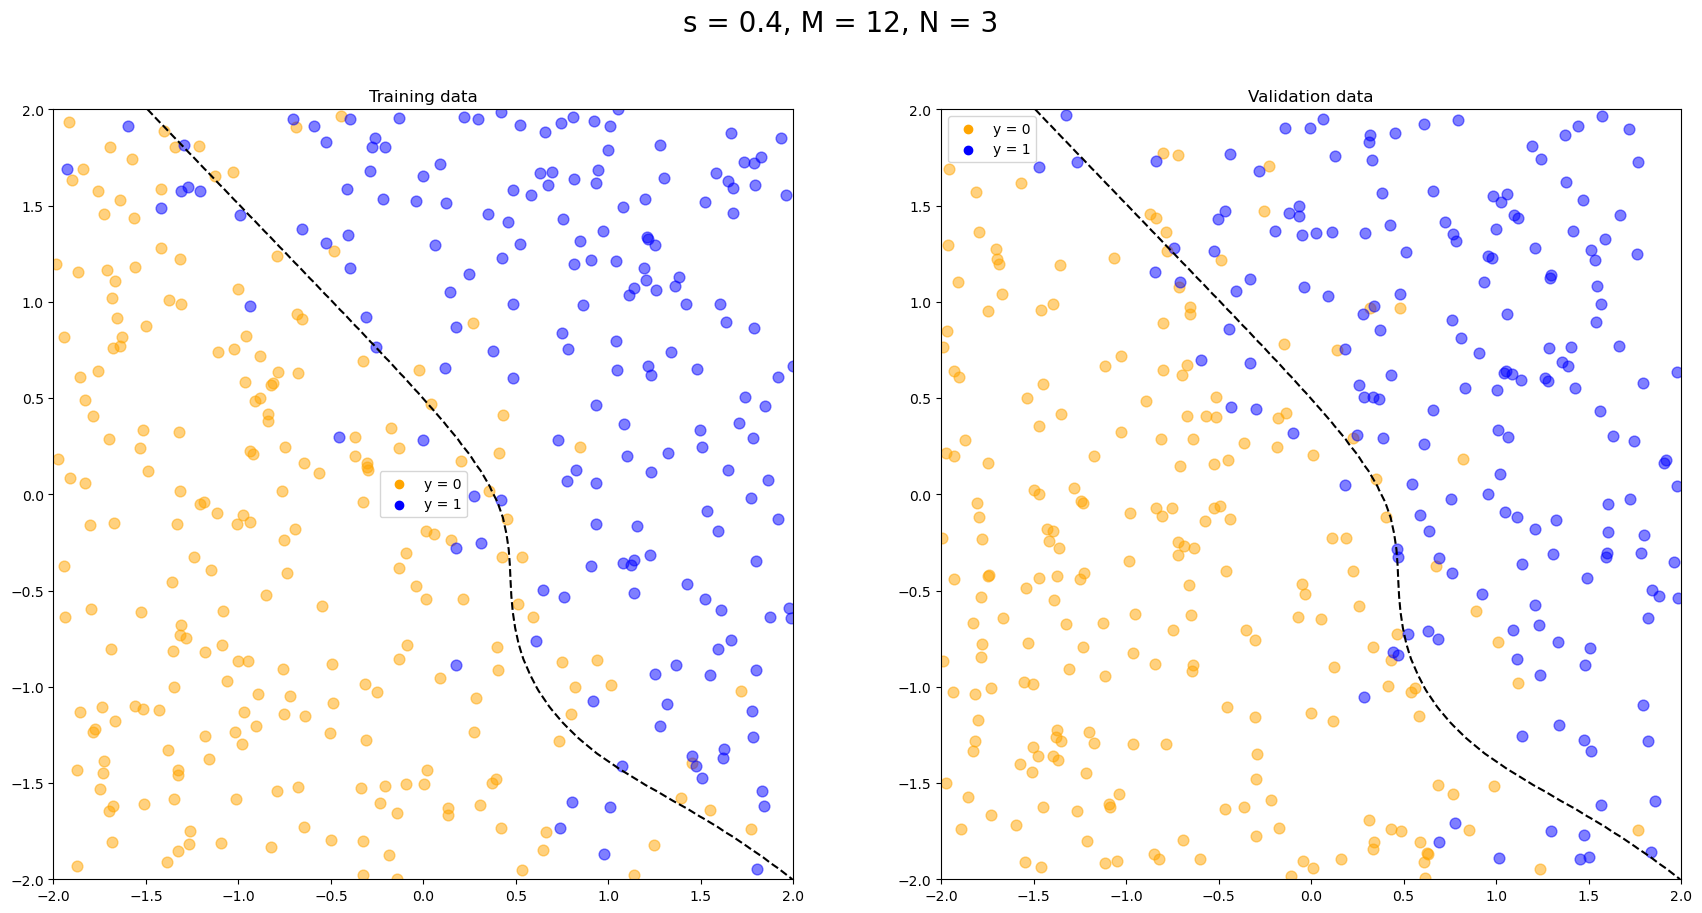

In [22]:
exp.plot_data()

In [23]:
exp.M = 3 # Capacity of model (polynomial degree)
exp.n_epochs = 0 # No training
exp.go() # Initialising untrained model
untrained_model_balanced = exp.model # Saving untrained model
untrained_err_balanced = exp.tst_err # Saving classification error for untrained model
# Learning parameters
exp.learning_rate = 0.1
exp.n_epochs = 500
exp.batch_size = 20
exp.n_print = 2000 # Print after every `n_print` epochs
exp.go() # Training model
trained_model_balanced = exp.model # Saving trained model
trained_err_balanced = exp.tst_err # Saving classification error for trained model  
ROC_trained_balanced, AUC_trained_balanced = give_ROC_AUC(trained_model_balanced,exp.x_tst_arr,exp.y_tst_arr)
ROC_untrained_balanced, AUC_untrained_balanced = give_ROC_AUC(untrained_model_balanced,exp.x_tst_arr,exp.y_tst_arr)

End. Training error: 0.817500. Testing error: 0.800000
Epoch 0. Training cost: 0.486557. Testing error: 0.172500
End. Training error: 0.102500. Testing error: 0.105000


In [24]:
print('AUC value for trained model (balanced dataset): ', AUC_trained_balanced)
print('AUC value for untrained model (balanced dataset): ', AUC_untrained_balanced)
print('Misclassification error for trained model (balanced dataset): ', trained_err_balanced.item())
print('Misclassification error for untrained model (balanced dataset): ', untrained_err_balanced.item())

AUC value for trained model (balanced dataset):  0.9717171717171673
AUC value for untrained model (balanced dataset):  0.09184343434343432
Misclassification error for trained model (balanced dataset):  0.10499999672174454
Misclassification error for untrained model (balanced dataset):  0.800000011920929


#### Imbalanced data

In [25]:
prop_0 = 0.05

Next, we create an imbalanced dataset. We do this by keeping only a proportion `prop_0` of the negative ($y = 0$) above datapoints.

In [26]:
def trim_0s(x_arr,y_arr,prop_0):
    '''
    Removes y=0 datapoints from `x_arr` and `y_arr` leaving a proportion of `prop_0` of teh original number.
    '''
    y_arr = y_arr.transpose()[0] # Transforming to sqs of 1s and 0s 
    prop_0 = 0.2 # Proportion of y=0 datapoints left
    N = len([i for i in y_arr if i == 0]) # Initial number of y=0 datapoints 
    N_new = math.ceil(N*prop_0)
    count = 0
    while count < (N - N_new):
        i = np.random.randint(0,len(y_arr))
        if y_arr[i] == 0:
            x_arr = np.delete(x_arr, i, axis = 0)
            y_arr = np.delete(y_arr, i)
            count +=1
    y_arr = y_arr.reshape((len(y_arr),1))# Transforming back to column vector
    return x_arr, y_arr

In [27]:
# Trimming training set 
x_arr = exp.x_arr; y_arr = exp.y_arr
exp.x_arr, exp.y_arr = trim_0s(x_arr,y_arr,prop_0)
# Trimming training set 
x_arr = exp.x_tst_arr; y_arr = exp.y_tst_arr
exp.x_tst_arr, exp.y_tst_arr = trim_0s(x_arr,y_arr,prop_0)

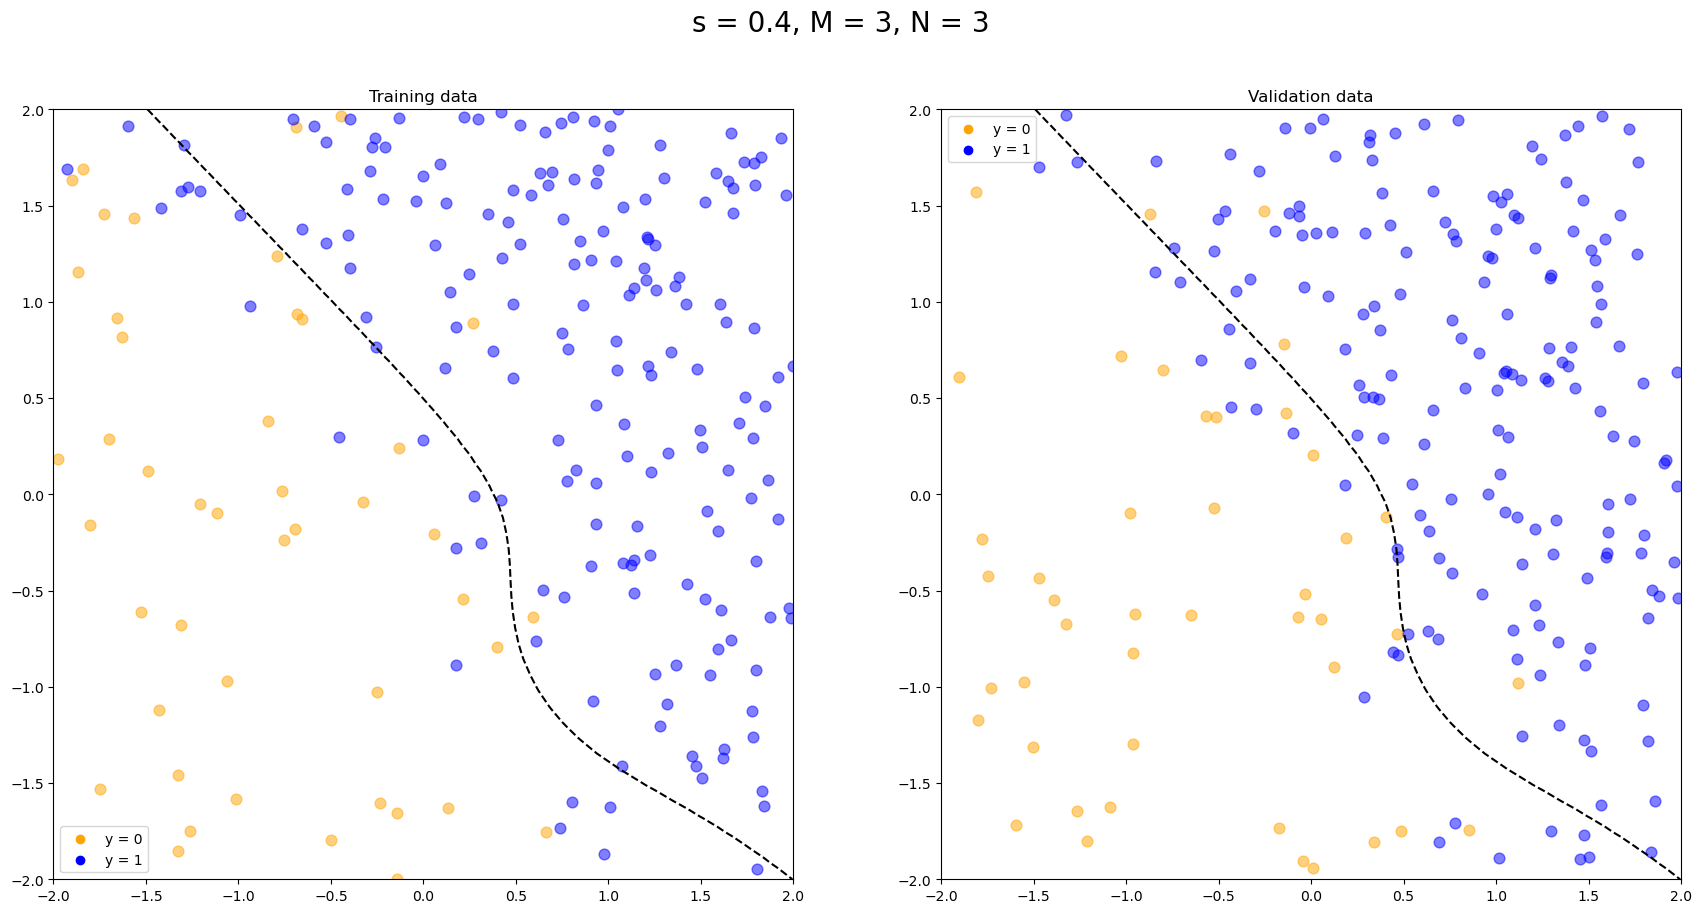

In [28]:
exp.plot_data()

In [29]:
exp.M = 3 # Capacity of model (polynomial degree)
exp.n_epochs = 0 # No training
exp.go() # Initialising untrained model
untrained_model_imbalanced = exp.model # Saving untrained model
untrained_err_imbalanced = exp.tst_err # Saving classification error for untrained model
# Learning parameters
exp.learning_rate = 0.1
exp.n_epochs = 500
exp.batch_size = 20
exp.n_print = 2000 # Print after every `n_print` epochs
exp.go() # Training model
trained_model_imbalanced = exp.model # Saving trained model
trained_err_imbalanced = exp.tst_err # Saving classification error for trained model  
ROC_trained_imbalanced, AUC_trained_imbalanced = give_ROC_AUC(trained_model_imbalanced,exp.x_tst_arr,exp.y_tst_arr)
ROC_untrained_imbalanced, AUC_untrained_imbalanced = give_ROC_AUC(untrained_model_imbalanced,exp.x_tst_arr,exp.y_tst_arr)

End. Training error: 0.286996. Testing error: 0.267857
Epoch 0. Training cost: 0.667962. Testing error: 0.120536
End. Training error: 0.067265. Testing error: 0.049107


In [30]:
print('AUC value for trained model (imbalanced dataset): ', AUC_trained_imbalanced)
print('AUC value for untrained model (imbalanced dataset): ', AUC_untrained_imbalanced)
print('Misclassification error for trained model (imbalanced dataset): ', trained_err_imbalanced.item())
print('Misclassification error for untrained model (imbalanced dataset): ', untrained_err_imbalanced.item())

AUC value for trained model (imbalanced dataset):  0.9703282828282822
AUC value for untrained model (imbalanced dataset):  0.38270202020202027
Misclassification error for trained model (imbalanced dataset):  0.0491071417927742
Misclassification error for untrained model (imbalanced dataset):  0.2678571343421936


We plot the ROC curves for both the balanced and imbalanced datasets.

In [31]:
# Transforming for below plots
ROC_trained_tb = np.array(ROC_trained_balanced).transpose(); ROC_untrained_tb = np.array(ROC_untrained_balanced).transpose()
ROC_trained_ti = np.array(ROC_trained_imbalanced).transpose(); ROC_untrained_ti = np.array(ROC_untrained_imbalanced).transpose()

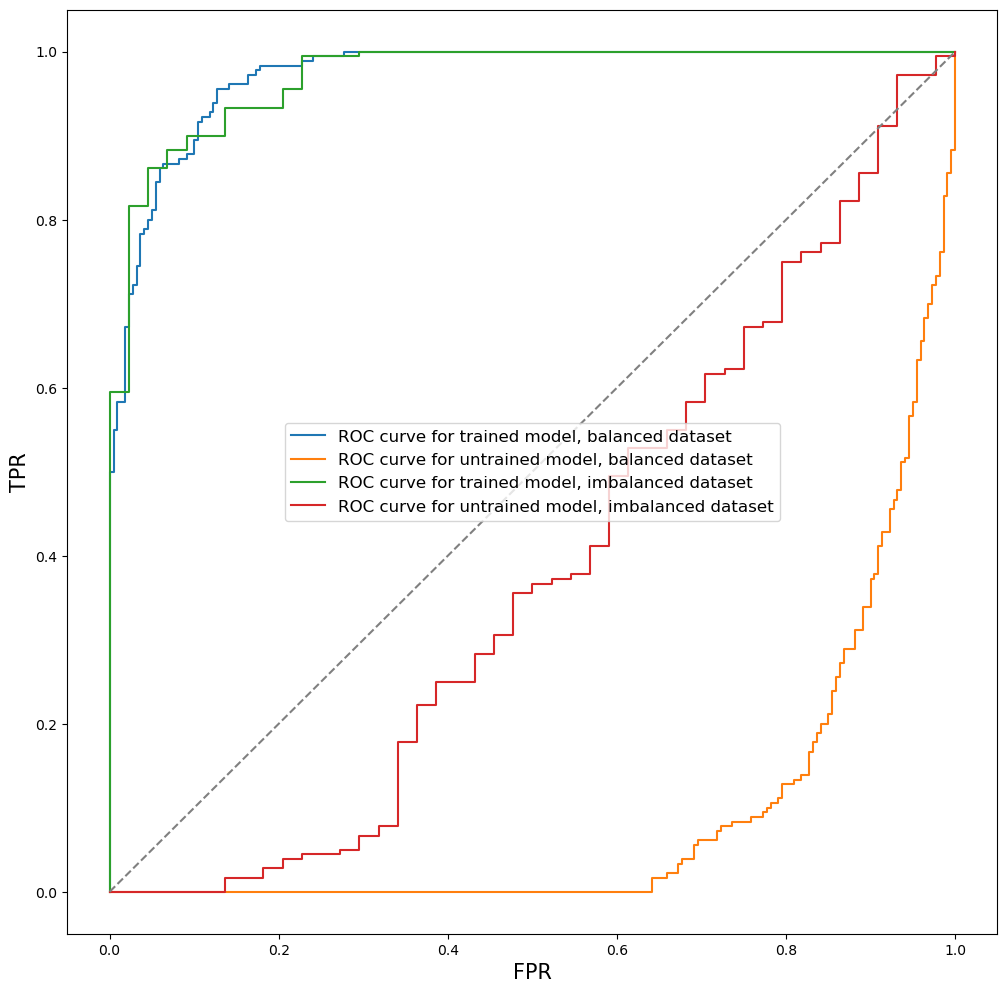

In [32]:
fig, ax = plt.subplots(1,1,figsize = (12,12))
ax.plot(ROC_trained_tb[0],ROC_trained_tb[1], label = 'ROC curve for trained model, balanced dataset')
ax.plot(ROC_untrained_tb[0],ROC_untrained_tb[1], label = 'ROC curve for untrained model, balanced dataset')
ax.plot(ROC_trained_ti[0],ROC_trained_ti[1], label = 'ROC curve for trained model, imbalanced dataset')
ax.plot(ROC_untrained_ti[0],ROC_untrained_ti[1], label = 'ROC curve for untrained model, imbalanced dataset')
ax.plot([0,1],[0,1], color = 'gray', linestyle = '--')
ax.legend(prop={'size': 12})
ax.set_xlabel('FPR', size = 15)
ax.set_ylabel('TPR', size = 15)
plt.show()

We compare the AUC and misclassification errors for the model trained on the balanced and imbalanced dataset with the following table.

In [33]:
df = pd.DataFrame({'AUC value': [AUC_trained_balanced,AUC_trained_imbalanced], 
                   'Misclassification error':[trained_err_balanced.item(),trained_err_imbalanced.item()]},
                     index = ['Balanced dataset','imbalanced dataset'])
df = df.style.set_properties(**{
    'font-size': '15pt'
})


In [34]:
display(df)

,AUC value,Misclassification error
Balanced dataset,0.971717,0.105000
imbalanced dataset,0.970328,0.049107


As we can see: 
- the misclassification error decreased (indicating *increased* classifier quality) for the imbalanced dataset,
- however, the AUC value decreased (indicating *decreased* classifier quality) for the imbalanced dataset. 

Note that the classifer for the imbalanced dataset was trained on less total data (a proportion of 0.55) compared to the balanced dataset, so from that perspective we would expect that the classifer quality decreases, as indicated by AUC value.